In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from transformers import ViTImageProcessor, TFViTForImageClassification
import os
# import keras
# print(keras.__version__)

In [16]:
DATA_ROOT_DIR = "./datasets/augmented train" # <--- IMPORTANT: Change this to your actual dataset path

# Define the number of personality classes you have (e.g., 5 for the Big Five).
NUM_CLASSES = 5

# Choose a pre-trained ViT model.
# 'google/vit-base-patch16-224' is a good starting point.
# You can explore other options like 'google/vit-large-patch16-224' for larger models.
MODEL_NAME = "google/vit-base-patch16-224"

# Set device to GPU if available, otherwise CPU
# TensorFlow automatically uses GPU if available.
print(f"TensorFlow version: {tf.__version__}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.15.1
Num GPUs Available: 1


In [17]:
# --- 1. Data Preparation ---

# Load the image processor associated with the pre-trained ViT model.
# This processor provides the expected image size and normalization parameters.
image_processor = ViTImageProcessor.from_pretrained(MODEL_NAME)

# Get the expected image size from the processor
IMG_HEIGHT = image_processor.size["height"]
IMG_WIDTH = image_processor.size["width"]

# Define batch size
BATCH_SIZE = 16 # You can adjust this based on your GPU memory

# Create the dataset using image_dataset_from_directory.
# This function automatically infers class labels from folder names.
# It expects a directory structure where each subdirectory represents a class.
try:
    # Load training dataset
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        DATA_ROOT_DIR,
        validation_split=0.2, # 20% for validation
        subset="training",
        seed=123, # For reproducible split
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        label_mode='int' # Labels will be integers (0, 1, 2, 3, 4)
    )

    # Load validation dataset
    val_dataset = tf.keras.utils.image_dataset_from_directory(
        DATA_ROOT_DIR,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        label_mode='int'
    )

    print(f"Found {train_dataset.cardinality().numpy() * BATCH_SIZE} training images and {val_dataset.cardinality().numpy() * BATCH_SIZE} validation images.")
    print(f"Detected classes: {train_dataset.class_names}")
    # Map class names to integer labels (if needed for reference)
    class_names = train_dataset.class_names
    class_to_idx = {name: i for i, name in enumerate(class_names)}
    print(f"Class to index mapping: {class_to_idx}")

except Exception as e:
    print(f"Error loading dataset from {DATA_ROOT_DIR}. Please check the path and structure.")
    print(f"Error details: {e}")
    print("Exiting. Please correct the DATA_ROOT_DIR and rerun.")
    exit() # Exit if dataset loading fails

# Preprocessing function for the dataset
# This function applies normalization required by the ViT model.
# ViT models from Hugging Face expect pixel values in the range [0, 1] for normalization,
# and then they apply their internal normalization (mean/std).
# So, we just need to rescale to [0, 1] here.
def preprocess_image(image, label):
    # Rescale pixel values from [0, 255] to [0, 1]
    # The ViT model from Hugging Face internally handles the mean/std normalization.
    image = layers.Rescaling(1./255)(image)
    
    # Transpose from (batch_size, height, width, channels) to (batch_size, channels, height, width)
    # The ViT model's internal patch embedding layer expects channels first,
    # and then it transposes back to channels last for its convolution.
    image = tf.transpose(image, perm=[0, 3, 1, 2]) # [batch, height, width, channels] -> [batch, channels, height, width]
    return image, label

# Apply preprocessing to both datasets
train_dataset = train_dataset.map(preprocess_image).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess_image).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print(f"\nTraining dataset batches: {train_dataset.cardinality().numpy()}")
print(f"Validation dataset batches: {val_dataset.cardinality().numpy()}")


Found 3416 files belonging to 5 classes.
Using 2733 files for training.
Found 3416 files belonging to 5 classes.


2025-05-21 14:35:36.094867: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:35:36.101328: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:35:36.102471: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:35:36.103254: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:35:36.104509: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:35:36.105698: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:35:36.106547: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


Using 683 files for validation.
Found 2736 training images and 688 validation images.
Detected classes: ['Agreeableness', 'Conscientiousness', 'Extraversion', 'Neuroticism', 'Openness']
Class to index mapping: {'Agreeableness': 0, 'Conscientiousness': 1, 'Extraversion': 2, 'Neuroticism': 3, 'Openness': 4}

Training dataset batches: 171
Validation dataset batches: 43


2025-05-21 14:35:36.301915: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:35:36.308294: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:35:36.309442: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:35:36.310232: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:35:36.311497: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:35:36.312648: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:35:36.313496: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:35:36.340105: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:35:36.341188: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:35:36

In [18]:
# --- 2. Load and Modify the Vision Transformer Model ---

# Load the pre-trained ViT model for image classification.
# 'num_labels' is set to your number of classes, which automatically modifies the final layer.
# 'id2label' and 'label2id' are used to map integer labels to class names, which can be useful
# for the model's internal configuration and for understanding predictions.
id2label = {str(i): name for i, name in enumerate(class_names)}
label2id = {name: str(i) for i, name in enumerate(class_names)}

model = TFViTForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_CLASSES,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True # <--- ADDED THIS LINE
)

print(f"\nModel loaded successfully: {MODEL_NAME}")
print(f"Number of output features in classifier: {model.config.num_labels}")
print(f"Expected number of output features: {NUM_CLASSES}")


2025-05-21 14:35:45.934815: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:35:45.936974: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:35:45.939075: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:35:45.940145: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:35:45.941996: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:35:45.943042: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:35:45.944667: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:35:45.945684: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:35:45.947407: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:35:45


Model loaded successfully: google/vit-base-patch16-224
Number of output features in classifier: 5
Expected number of output features: 5


In [61]:
callbacks = [
    # keras.callbacks.ModelCheckpoint(
    #     filepath=f"./train_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}/save_at_epoch_{{epoch:02d}}.keras",
    #     monitor='val_accuracy',
    #     save_best_only=True
    # ),
    # keras.callbacks.BackupAndRestore(
    #     './backup_model',
    #     save_freq="epoch",
    #     double_checkpoint=False,
    #     delete_checkpoint=True
    # ),
    tf.keras.callbacks.TensorBoard(
        # log_dir=f"logs_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}",
        log_dir="log",
        histogram_freq=0,
        write_graph=True,
        write_images=False,
        write_steps_per_second=False,
        update_freq="epoch",
        profile_batch=0,
        embeddings_freq=0,
        embeddings_metadata=None,
    ),
    # keras.callbacks.EarlyStopping(
    #     monitor='accuracy',       # Monitor training accuracy
    #     mode='max',              # Stop when accuracy stops increasing
    #     baseline=0.95,           # Stop when accuracy reaches 95%
    #     patience=0,              # Stop immediately when the baseline is reached
    #     verbose=1                # Print a message when training stops
    # )
]

In [63]:
# --- 3. Basic Training Loop ---
# This section shows how you would typically compile and train the model.

print("\n--- Model and Data Loaders are ready ---")
print("Now proceeding with defining your optimizer, loss function, and training loop.")

# Define optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
# Use SparseCategoricalCrossentropy because labels are integers (0, 1, 2, 3, 4)
# from image_dataset_from_directory, and we want to compute loss from logits.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

# Compile the model
model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

print("\nModel compiled. Ready for training.")

# Example of how to train the model
EPOCHS = 10 # You can adjust the number of epochs
print(f"\nStarting training for {EPOCHS} epochs...")
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)
print("\nTraining complete.")




--- Model and Data Loaders are ready ---
Now proceeding with defining your optimizer, loss function, and training loop.

Model compiled. Ready for training.

Starting training for 10 epochs...
Epoch 1/10


2025-05-21 15:17:42.290493: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 15:18:01.329693: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


171/171 [==============================] - ETA: 0s - loss: 0.0474 - accuracy: 0.9865

2025-05-21 15:18:33.694106: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


171/171 [==============================] - 54s 162ms/step - loss: 0.0474 - accuracy: 0.9865 - val_loss: 0.0531 - val_accuracy: 0.9883
Epoch 2/10
171/171 [==============================] - 25s 149ms/step - loss: 0.0074 - accuracy: 0.9978 - val_loss: 0.0756 - val_accuracy: 0.9766
Epoch 3/10
171/171 [==============================] - 25s 148ms/step - loss: 0.0216 - accuracy: 0.9934 - val_loss: 0.0481 - val_accuracy: 0.9854
Epoch 4/10
171/171 [==============================] - 25s 149ms/step - loss: 5.3149e-04 - accuracy: 1.0000 - val_loss: 0.0494 - val_accuracy: 0.9898
Epoch 5/10
171/171 [==============================] - 25s 149ms/step - loss: 1.6755e-04 - accuracy: 1.0000 - val_loss: 0.0499 - val_accuracy: 0.9883
Epoch 6/10
171/171 [==============================] - 25s 148ms/step - loss: 1.3011e-04 - accuracy: 1.0000 - val_loss: 0.0504 - val_accuracy: 0.9868
Epoch 7/10
171/171 [==============================] - 25s 148ms/step - loss: 1.0756e-04 - accuracy: 1.0000 - val_loss: 0.0508 - v

2025-05-21 15:22:24.806422: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


In [22]:
import datetime

print("\n--- Saving the Trained Model ---")
# Create a directory for saved models if it doesn't exist
SAVE_DIR = "trained_vit_model_perfect"
os.makedirs(SAVE_DIR, exist_ok=True)

# Generate a timestamp for the model name
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_save_path = os.path.join(SAVE_DIR, f"personality_vit_{timestamp}")

# Use the save_pretrained method for Hugging Face models
model.save_pretrained(model_save_path)
print(f"Model saved to: {model_save_path}")


--- Saving the Trained Model ---
Model saved to: trained_vit_model/personality_vit_20250521-144334


In [10]:
# Example of making a prediction on a single batch from the validation set
if val_dataset.cardinality().numpy() > 0:
    print("\n--- Example Prediction ---")
    for images, labels in val_dataset.take(1): # Take one batch from validation set
        print(f"Input batch shape: {images.shape}") # Expected: [BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3]
        print(f"Labels batch shape: {labels.shape}") # Expected: [BATCH_SIZE]
        print(f"Sample labels: {labels.numpy()[:5].tolist()}")

        # Make predictions
        predictions = model.predict(images)
        logits = predictions.logits # Get the raw predictions before softmax
        predicted_classes = tf.argmax(logits, axis=-1) # Get the class with the highest logit

        print(f"Output logits shape: {logits.shape}") # Expected: [BATCH_SIZE, NUM_CLASSES]
        print(f"Sample predicted classes: {predicted_classes.numpy()[:5].tolist()}")
        print(f"Sample true labels: {labels.numpy()[:5].tolist()}")

        # You can map predicted_classes back to class names using `class_names` list
        # For example: print(f"Predicted personality: {class_names[predicted_classes[0].numpy()]}")
        break
else:
    print("Validation dataset is empty. No batches to process for example prediction.")

print("\nSetup complete. You are ready to define and run your training logic.")



--- Example Prediction ---
Input batch shape: (16, 3, 224, 224)
Labels batch shape: (16,)
Sample labels: [3, 3, 3, 0, 3]


2025-05-21 14:28:35.177376: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:28:35.199169: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:28:35.202092: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:28:35.203237: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:28:35.208385: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:28:35.209354: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:28:35.217896: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:28:35.219065: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:28:35.219805: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:28:35

1/1 [==============================] - 2s 2s/step
Output logits shape: (16, 5)
Sample predicted classes: [3, 3, 3, 0, 3]
Sample true labels: [3, 3, 3, 0, 3]

Setup complete. You are ready to define and run your training logic.


2025-05-21 14:28:36.765924: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:28:36.873410: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


In [43]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    "./datasets/augmented test",
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=16, # Use a larger batch size if your GPU can handle it,
                    # or keep 1 for individual display if you want.
                    # The error suggests the issue is with image dimensions, not batch size.
    label_mode='int',
    shuffle=False,
    interpolation='bilinear', # Default is 'bilinear'
    # data_format='channels_last' # This is the default, so explicitly setting it is redundant but clarifies intent
)

Found 663 files belonging to 5 classes.


2025-05-21 15:00:38.306549: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 15:00:38.313279: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 15:00:38.314492: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 15:00:38.315286: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 15:00:38.316257: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 15:00:38.317119: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.



--- Example Prediction ---
1/1 [==============================] - 0s 75ms/step


2025-05-21 15:05:54.716065: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 15:05:54.728375: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 15:05:54.729324: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 15:05:54.734453: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 15:05:54.735371: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 15:05:54.742394: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 15:05:54.743426: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 15:05:54.744119: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 15:05:54.744885: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 15:05:54

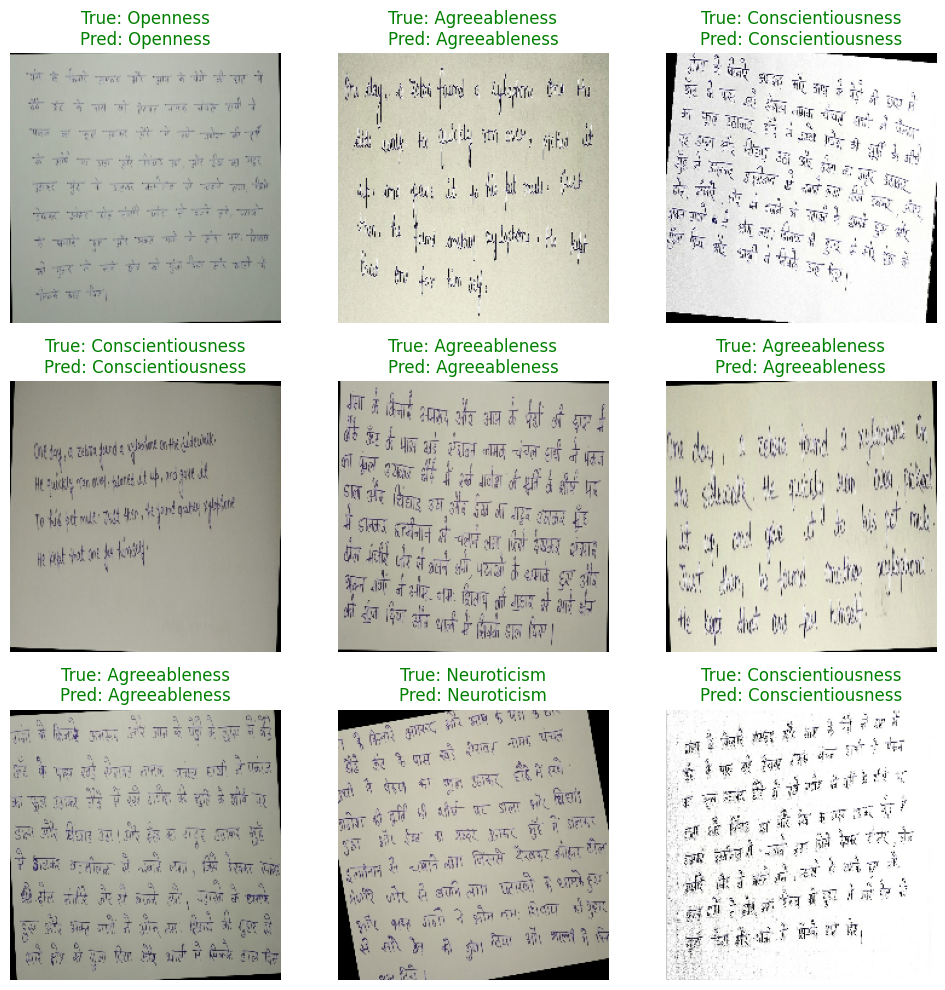


Setup complete. You are ready to define and run your training logic.


In [51]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

if val_dataset.cardinality().numpy() > 0:
    print("\n--- Example Prediction ---")
    for images, labels in val_dataset.take(1): # Take one batch from validation set
        # Make predictions
        predictions = model.predict(images)
        logits = predictions.logits
        predicted_classes = tf.argmax(logits, axis=-1)

        # --- Visualization with Matplotlib ---
        plt.figure(figsize=(10, 10))
        for i in range(min(9, images.shape[0])): # Display up to 9 images
            ax = plt.subplot(3, 3, i + 1)
            
            # Transpose from (channels, height, width) to (height, width, channels)
            # and scale to 0-255 for uint8 display
            display_image = images[i].numpy().transpose(1, 2, 0)
            display_image = (display_image * 255).astype("uint8")

            plt.imshow(display_image)
            
            true_label = labels.numpy()[i]
            predicted_label = predicted_classes.numpy()[i]
            
            # Assuming 'class_names' is defined and available
            title_text = f"True: {class_names[true_label]}" if 'class_names' in locals() or 'class_names' in globals() else f"True: {true_label}"
            title_text += f"\nPred: {class_names[predicted_label]}" if 'class_names' in locals() or 'class_names' in globals() else f"\nPred: {predicted_label}"
            
            color = "green" if true_label == predicted_label else "red"
            plt.title(title_text, color=color)
            plt.axis("off")
        plt.tight_layout()
        plt.show()
        # --- End Visualization ---

        break # Only process one batch for the example
else:
    print("Validation dataset is empty. No batches to process for example prediction.")

print("\nSetup complete. You are ready to define and run your training logic.")

In [28]:
# --- New Cell: Loading the Saved Model (for demonstration) ---
print("\n--- Loading the Saved Model ---")
# To load the model back, use from_pretrained with the path to the saved directory
loaded_model = TFViTForImageClassification.from_pretrained(model_save_path)
print(f"Model loaded successfully from: {model_save_path}")



--- Loading the Saved Model ---


2025-05-21 14:49:23.932800: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:49:23.934950: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:49:23.936781: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:49:23.937940: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:49:23.939708: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:49:23.940830: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:49:23.942492: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:49:23.943578: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:49:23.945230: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-05-21 14:49:23

Model loaded successfully from: trained_vit_model/personality_vit_20250521-144334


In [ ]:
# --- New Cell: Display OCEAN Trait Percentages ---
import tensorflow as tf
import numpy as np

# Define the OCEAN traits in their standard order
# Replace these with your actual class names if they're different
ocean_traits = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']

# Print the detected class names from your dataset to verify the order
print("Detected classes (verify these match OCEAN order):", class_names)

# Create a mapping from detected class index to OCEAN trait index if needed
# This is important if your class names order doesn't match the OCEAN order
class_to_ocean = {}
for i, class_name in enumerate(class_names):
    # You'll need to determine the mapping based on your class names
    # For example, if class_names[0] is 'Extraversion', then class_to_ocean[0] = 2
    # (since Extraversion is index 2 in the ocean_traits list)
    
    # For now, let's assume the class names directly correspond to OCEAN traits
    # But you'll need to adjust this mapping based on your actual class names
    class_to_ocean[i] = i

print("Class to OCEAN trait mapping:", class_to_ocean)

# Make predictions on a sample image
if val_dataset.cardinality().numpy() > 0:
    for images, labels in val_dataset.take(1):
        # Take the first image as an example
        image = tf.expand_dims(images[0], 0)  # Add batch dimension
        
        # Make prediction
        predictions = model.predict(image)
        logits = predictions.logits[0]  # Get logits for the first image
        
        # Convert logits to probabilities using softmax
        probabilities = tf.nn.softmax(logits).numpy() * 100  # Convert to percentages
        
        # Print the percentages for each OCEAN trait
        print("\nOCEAN Trait Percentages:")
        print("-" * 25)
        
        # Method 1: Direct mapping if class order matches OCEAN order
        print("Method 1 (assuming class order matches OCEAN order):")
        for i, trait in enumerate(ocean_traits):
            print(f"{trait}: {probabilities[i]:.2f}%")
        
        # Method 2: Using the class to OCEAN mapping
        print("\nMethod 2 (using the class to OCEAN mapping):")
        ocean_percentages = np.zeros(5)
        for class_idx, ocean_idx in class_to_ocean.items():
            ocean_percentages[ocean_idx] = probabilities[class_idx]
        
        for i, trait in enumerate(ocean_traits):
            print(f"{trait}: {ocean_percentages[i]:.2f}%")
            
        # Show the predicted class name for reference
        predicted_class = tf.argmax(logits).numpy()
        print(f"\nPredicted dominant trait: {class_names[predicted_class]} (class index: {predicted_class})")
        
        # Display the image
        plt.figure(figsize=(6, 6))
        
        # Transpose and rescale the image for display
        display_image = image[0].numpy().transpose(1, 2, 0)
        display_image = (display_image * 255).astype("uint8")
        
        plt.imshow(display_image)
        plt.title(f"Predicted: {class_names[predicted_class]}")
        plt.axis("off")
        plt.show()
        
        # Create a bar chart of the OCEAN percentages
        plt.figure(figsize=(10, 6))
        bars = plt.bar(ocean_traits, ocean_percentages, color=['blue', 'green', 'red', 'purple', 'orange'])
        
        # Add percentage labels on top of the bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{height:.1f}%', ha='center', va='bottom')
        
        plt.title('OCEAN Personality Traits Percentages')
        plt.ylabel('Percentage')
        plt.ylim(0, 100)  # Set y-axis from 0% to 100%
        plt.show()
        break
else:
    print("Validation dataset is empty. No images to process.")